In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Path to your GloVe pre-trained embeddings file
glove_file_path = 'glove.6B.300d.txt'

# Load GloVe embeddings
model = load_glove_model(glove_file_path)

Loading Glove Model
400000 words loaded!


In [4]:
word_embedding = model.get('hello')
print((word_embedding))

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [5]:

def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            # Check if word exists in the model's vocabulary
            if word in model:
                embedding.append(model[word])
            else:
                # If word not found, use zero vector
                embedding.append([0] * model["hello"].size)
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83  # maximum length of word in a text
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * model["hello"].size] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    # Filter out None values
    padded_embeddings = [embedding for embedding in padded_embeddings if embedding is not None]

    # Convert to tensor
    input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)

    return input_ids

In [6]:
x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_33202/886969634.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)


In [7]:
x_train.size()

torch.Size([906, 83, 300])

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([906, 83])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [12]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = GRUTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_33202/3447244848.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_33202/3447244848.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_33202/3447244848.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_33202/3447244848.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/150, Train Loss: 1.0555734932422638, Val Loss: 0.5716670155525208, Val F1: 0.34412926764654633, Train F1: 0.24947189093408698


  1%|█▉                                                                                                                                                | 2/150 [00:00<01:05,  2.26it/s]

Epoch 2/150, Train Loss: 0.4960070811212063, Val Loss: 0.45635634660720825, Val F1: 0.33270201476815014, Train F1: 0.32906999981508145


  2%|██▉                                                                                                                                               | 3/150 [00:01<01:02,  2.35it/s]

Epoch 3/150, Train Loss: 0.4695638306438923, Val Loss: 0.3889312148094177, Val F1: 0.3419116098207691, Train F1: 0.3143935401114815


  3%|███▉                                                                                                                                              | 4/150 [00:01<01:01,  2.39it/s]

Epoch 4/150, Train Loss: 0.4108840599656105, Val Loss: 0.3793167471885681, Val F1: 0.3868284627274569, Train F1: 0.32233654339693846


  3%|████▊                                                                                                                                             | 5/150 [00:02<01:00,  2.42it/s]

Epoch 5/150, Train Loss: 0.3865642808377743, Val Loss: 0.351242333650589, Val F1: 0.4316981918154051, Train F1: 0.3538674048997941


  4%|█████▊                                                                                                                                            | 6/150 [00:02<00:58,  2.45it/s]

Epoch 6/150, Train Loss: 0.35770587995648384, Val Loss: 0.33166083693504333, Val F1: 0.42492553350569845, Train F1: 0.3712009318706634


  5%|██████▊                                                                                                                                           | 7/150 [00:02<00:58,  2.46it/s]

Epoch 7/150, Train Loss: 0.3353635389357805, Val Loss: 0.317645400762558, Val F1: 0.4655715136373335, Train F1: 0.3783928358220081


  5%|███████▊                                                                                                                                          | 8/150 [00:03<00:57,  2.47it/s]

Epoch 8/150, Train Loss: 0.31668725796043873, Val Loss: 0.3062688708305359, Val F1: 0.5006637859788664, Train F1: 0.4077837782034241


  6%|████████▊                                                                                                                                         | 9/150 [00:03<00:56,  2.48it/s]

Epoch 9/150, Train Loss: 0.32444843649864197, Val Loss: 0.2946983277797699, Val F1: 0.5221723569422939, Train F1: 0.4606251668624327


  7%|█████████▋                                                                                                                                       | 10/150 [00:04<00:57,  2.45it/s]

Epoch 10/150, Train Loss: 0.31907637417316437, Val Loss: 0.2845396399497986, Val F1: 0.5664825671443826, Train F1: 0.4781521334687745


  7%|██████████▋                                                                                                                                      | 11/150 [00:04<00:56,  2.46it/s]

Epoch 11/150, Train Loss: 0.2948014587163925, Val Loss: 0.2759019136428833, Val F1: 0.6175112608750982, Train F1: 0.5379170050013219


  8%|███████████▌                                                                                                                                     | 12/150 [00:04<00:56,  2.44it/s]

Epoch 12/150, Train Loss: 0.27693129889667034, Val Loss: 0.2674238085746765, Val F1: 0.6301304265509963, Train F1: 0.6002487569536905


  9%|████████████▌                                                                                                                                    | 13/150 [00:05<00:56,  2.43it/s]

Epoch 13/150, Train Loss: 0.2670889124274254, Val Loss: 0.2600764036178589, Val F1: 0.640190085364707, Train F1: 0.6007062755117921


  9%|█████████████▌                                                                                                                                   | 14/150 [00:05<00:55,  2.45it/s]

Epoch 14/150, Train Loss: 0.2666134759783745, Val Loss: 0.25379908084869385, Val F1: 0.6586064300510402, Train F1: 0.6398490925501443


 10%|██████████████▌                                                                                                                                  | 15/150 [00:06<00:55,  2.44it/s]

Epoch 15/150, Train Loss: 0.26535152085125446, Val Loss: 0.24793927371501923, Val F1: 0.6751432428005995, Train F1: 0.6462483339924137


 11%|███████████████▍                                                                                                                                 | 16/150 [00:06<00:54,  2.44it/s]

Epoch 16/150, Train Loss: 0.25424223579466343, Val Loss: 0.242671400308609, Val F1: 0.6684688532027981, Train F1: 0.6754024848380478


 11%|████████████████▍                                                                                                                                | 17/150 [00:06<00:54,  2.45it/s]

Epoch 17/150, Train Loss: 0.25193181075155735, Val Loss: 0.237958624958992, Val F1: 0.673215957924719, Train F1: 0.6889968584048147


 12%|█████████████████▍                                                                                                                               | 18/150 [00:07<00:53,  2.45it/s]

Epoch 18/150, Train Loss: 0.2494234349578619, Val Loss: 0.2336903214454651, Val F1: 0.6709979531944515, Train F1: 0.6981247133803112


 13%|██████████████████▎                                                                                                                              | 19/150 [00:07<00:53,  2.47it/s]

Epoch 19/150, Train Loss: 0.2332102209329605, Val Loss: 0.22913162410259247, Val F1: 0.6953026692382193, Train F1: 0.7099908499508949


 13%|███████████████████▎                                                                                                                             | 20/150 [00:08<00:53,  2.43it/s]

Epoch 20/150, Train Loss: 0.22610882110893726, Val Loss: 0.22457289695739746, Val F1: 0.6994515210342548, Train F1: 0.7391956480893451


 14%|████████████████████▎                                                                                                                            | 21/150 [00:08<00:53,  2.40it/s]

Epoch 21/150, Train Loss: 0.22732574678957462, Val Loss: 0.2212398797273636, Val F1: 0.7166395136280479, Train F1: 0.7484271558190299


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:09<00:53,  2.41it/s]

Epoch 22/150, Train Loss: 0.21314213424921036, Val Loss: 0.22084255516529083, Val F1: 0.694725539623762, Train F1: 0.7489243638900809


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:09<00:53,  2.40it/s]

Epoch 23/150, Train Loss: 0.21361846663057804, Val Loss: 0.21826860308647156, Val F1: 0.7330285377015083, Train F1: 0.7333087827460708


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:09<00:53,  2.37it/s]

Epoch 24/150, Train Loss: 0.21054059267044067, Val Loss: 0.21412613987922668, Val F1: 0.7158534917396765, Train F1: 0.7660815805054603


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:10<00:52,  2.39it/s]

Epoch 25/150, Train Loss: 0.2064495664089918, Val Loss: 0.21081426739692688, Val F1: 0.7273784600662668, Train F1: 0.7610890518690732


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:10<00:51,  2.41it/s]

Epoch 26/150, Train Loss: 0.19394000247120857, Val Loss: 0.21127432584762573, Val F1: 0.710430051486024, Train F1: 0.773413058351475


 18%|██████████████████████████                                                                                                                       | 27/150 [00:11<00:51,  2.37it/s]

Epoch 27/150, Train Loss: 0.1840936467051506, Val Loss: 0.2052597999572754, Val F1: 0.7348482793880439, Train F1: 0.7713831997853876


 19%|███████████████████████████                                                                                                                      | 28/150 [00:11<00:51,  2.39it/s]

Epoch 28/150, Train Loss: 0.19371994026005268, Val Loss: 0.20274755358695984, Val F1: 0.7345277412987858, Train F1: 0.7663257729407533


 19%|████████████████████████████                                                                                                                     | 29/150 [00:11<00:50,  2.39it/s]

Epoch 29/150, Train Loss: 0.17882869951426983, Val Loss: 0.20116889476776123, Val F1: 0.7345904283894605, Train F1: 0.7942478970019249


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:12<00:50,  2.37it/s]

Epoch 30/150, Train Loss: 0.17298487573862076, Val Loss: 0.19824832677841187, Val F1: 0.7399102002704323, Train F1: 0.7923650208390373


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:12<00:49,  2.38it/s]

Epoch 31/150, Train Loss: 0.16656119748950005, Val Loss: 0.19711311161518097, Val F1: 0.7429190469659522, Train F1: 0.8006029252134815


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:13<00:48,  2.41it/s]

Epoch 32/150, Train Loss: 0.16849162988364697, Val Loss: 0.19444893300533295, Val F1: 0.7514754968664343, Train F1: 0.7874695176243488


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:13<00:48,  2.41it/s]

Epoch 33/150, Train Loss: 0.15699028875678778, Val Loss: 0.19378753006458282, Val F1: 0.7363210233747584, Train F1: 0.8014336912266598


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:14<00:48,  2.40it/s]

Epoch 34/150, Train Loss: 0.15184821467846632, Val Loss: 0.1898707002401352, Val F1: 0.7519773984245935, Train F1: 0.8211781937254196


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:14<00:47,  2.42it/s]

Epoch 35/150, Train Loss: 0.16500418074429035, Val Loss: 0.18904149532318115, Val F1: 0.747297509187323, Train F1: 0.811984211407894


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:14<00:46,  2.44it/s]

Epoch 36/150, Train Loss: 0.14560843538492918, Val Loss: 0.18810132145881653, Val F1: 0.7382418031785277, Train F1: 0.8267555678021167


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:15<00:45,  2.46it/s]

Epoch 37/150, Train Loss: 0.1525682583451271, Val Loss: 0.18945614993572235, Val F1: 0.7384692824148879, Train F1: 0.8351073547326339


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:15<00:46,  2.41it/s]

Epoch 38/150, Train Loss: 0.1419774079695344, Val Loss: 0.18805444240570068, Val F1: 0.7548557886159729, Train F1: 0.8332148576673214


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:16<00:45,  2.44it/s]

Epoch 39/150, Train Loss: 0.14103568345308304, Val Loss: 0.1857399046421051, Val F1: 0.7495294865976678, Train F1: 0.8486914444314573


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:16<00:45,  2.44it/s]

Epoch 40/150, Train Loss: 0.149823316372931, Val Loss: 0.18576005101203918, Val F1: 0.7531807881686651, Train F1: 0.8499212594795872


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:16<00:44,  2.43it/s]

Epoch 41/150, Train Loss: 0.13857688661664724, Val Loss: 0.19261035323143005, Val F1: 0.7336343917456453, Train F1: 0.842202701376462


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:17<00:44,  2.41it/s]

Epoch 42/150, Train Loss: 0.12252368591725826, Val Loss: 0.18310987949371338, Val F1: 0.7468164838411052, Train F1: 0.864866006643444


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:17<00:44,  2.42it/s]

Epoch 43/150, Train Loss: 0.12932887952774763, Val Loss: 0.18662643432617188, Val F1: 0.7612483323057976, Train F1: 0.85081546396814


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:18<00:43,  2.44it/s]

Epoch 44/150, Train Loss: 0.11890171468257904, Val Loss: 0.18258528411388397, Val F1: 0.7496408841169598, Train F1: 0.8667932552667812


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:18<00:43,  2.43it/s]

Epoch 45/150, Train Loss: 0.11571845132857561, Val Loss: 0.1859421283006668, Val F1: 0.7413012364960876, Train F1: 0.8716430654697447


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:19<00:43,  2.42it/s]

Epoch 46/150, Train Loss: 0.10983800329267979, Val Loss: 0.18235167860984802, Val F1: 0.7544615140733885, Train F1: 0.8726832544297226


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:19<00:42,  2.43it/s]

Epoch 47/150, Train Loss: 0.11272841412574053, Val Loss: 0.18057742714881897, Val F1: 0.7609587665570436, Train F1: 0.8750051409532427


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:19<00:41,  2.44it/s]

Epoch 48/150, Train Loss: 0.1009176429361105, Val Loss: 0.17885106801986694, Val F1: 0.7570968092579898, Train F1: 0.8924494077209035


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:20<00:42,  2.39it/s]

Epoch 49/150, Train Loss: 0.09648608276620507, Val Loss: 0.17901171743869781, Val F1: 0.7611521798566759, Train F1: 0.9050104363905909


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:20<00:41,  2.41it/s]

Epoch 50/150, Train Loss: 0.10090465378016233, Val Loss: 0.18271176517009735, Val F1: 0.7530279227955812, Train F1: 0.9017392658350967


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:21<00:40,  2.43it/s]

Epoch 51/150, Train Loss: 0.09645138029009104, Val Loss: 0.18151617050170898, Val F1: 0.7546098437398028, Train F1: 0.8891170611167183


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:21<00:39,  2.45it/s]

Epoch 52/150, Train Loss: 0.09945032745599747, Val Loss: 0.18231652677059174, Val F1: 0.7579038901778207, Train F1: 0.8958840283352008


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:21<00:39,  2.44it/s]

Epoch 53/150, Train Loss: 0.09541919361799955, Val Loss: 0.18029867112636566, Val F1: 0.7700215993231615, Train F1: 0.9062908879173898


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:22<00:39,  2.41it/s]

Epoch 54/150, Train Loss: 0.09702887199819088, Val Loss: 0.18340176343917847, Val F1: 0.7721320780261571, Train F1: 0.9043575695185427


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:22<00:38,  2.44it/s]

Epoch 55/150, Train Loss: 0.08527612965553999, Val Loss: 0.18162615597248077, Val F1: 0.769570275901572, Train F1: 0.9161932520683109


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:23<00:39,  2.40it/s]

Epoch 56/150, Train Loss: 0.08167638070881367, Val Loss: 0.1827487051486969, Val F1: 0.7624549746946911, Train F1: 0.9198713540513448


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:23<00:38,  2.41it/s]

Epoch 57/150, Train Loss: 0.08586692065000534, Val Loss: 0.185017392039299, Val F1: 0.7605516458867764, Train F1: 0.9187460784743099


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:23<00:37,  2.44it/s]

Epoch 58/150, Train Loss: 0.07757506798952818, Val Loss: 0.18530148267745972, Val F1: 0.7661367574378791, Train F1: 0.9238680524099668


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:24<00:37,  2.43it/s]

Epoch 59/150, Train Loss: 0.08701408002525568, Val Loss: 0.18523095548152924, Val F1: 0.7761045747273259, Train F1: 0.916436423243744


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:24<00:37,  2.38it/s]

Epoch 60/150, Train Loss: 0.07923724222928286, Val Loss: 0.18669334053993225, Val F1: 0.7583946685580948, Train F1: 0.9309008732443803


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:25<00:36,  2.41it/s]

Epoch 61/150, Train Loss: 0.07503302861005068, Val Loss: 0.1911308765411377, Val F1: 0.750361444859959, Train F1: 0.9215994551847463


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:25<00:36,  2.44it/s]

Epoch 62/150, Train Loss: 0.06859468715265393, Val Loss: 0.18934129178524017, Val F1: 0.7595859795154524, Train F1: 0.9421698391445285


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:26<00:35,  2.45it/s]

Epoch 63/150, Train Loss: 0.0666375239379704, Val Loss: 0.19261884689331055, Val F1: 0.7584664853713073, Train F1: 0.9425295746911154


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:26<00:34,  2.47it/s]

Epoch 64/150, Train Loss: 0.06783829908818007, Val Loss: 0.1904800981283188, Val F1: 0.7603027746638752, Train F1: 0.9420913468133962


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:26<00:34,  2.48it/s]

Epoch 65/150, Train Loss: 0.06085577141493559, Val Loss: 0.19113709032535553, Val F1: 0.769497182345324, Train F1: 0.943676372279796


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:27<00:33,  2.48it/s]

Epoch 66/150, Train Loss: 0.06235938472673297, Val Loss: 0.19660651683807373, Val F1: 0.7501410228354075, Train F1: 0.9472952075872497


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:27<00:33,  2.49it/s]

Epoch 67/150, Train Loss: 0.05820052372291684, Val Loss: 0.19636739790439606, Val F1: 0.7529302941431241, Train F1: 0.9565924022921637


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:28<00:32,  2.50it/s]

Epoch 68/150, Train Loss: 0.05640396988019347, Val Loss: 0.19707553088665009, Val F1: 0.7607926516914447, Train F1: 0.9556340956340894


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:28<00:32,  2.47it/s]

Epoch 69/150, Train Loss: 0.05362441064789891, Val Loss: 0.20188885927200317, Val F1: 0.7542026113004224, Train F1: 0.9569924962516584


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:28<00:32,  2.47it/s]

Epoch 70/150, Train Loss: 0.05475692870095372, Val Loss: 0.20534159243106842, Val F1: 0.748087241594698, Train F1: 0.9597805425869476


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:29<00:31,  2.47it/s]

Epoch 71/150, Train Loss: 0.059827832505106926, Val Loss: 0.20822760462760925, Val F1: 0.7464372072736977, Train F1: 0.9475616339932872


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:29<00:31,  2.45it/s]

Epoch 72/150, Train Loss: 0.053323134779930115, Val Loss: 0.2166464775800705, Val F1: 0.7402788384094835, Train F1: 0.9522527199665096


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:30<00:31,  2.41it/s]

Epoch 73/150, Train Loss: 0.05421582981944084, Val Loss: 0.21626406908035278, Val F1: 0.745781208146147, Train F1: 0.9439591634555455


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:30<00:31,  2.41it/s]

Epoch 74/150, Train Loss: 0.051455043721944094, Val Loss: 0.2203831821680069, Val F1: 0.743254187193382, Train F1: 0.9548072533243551


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:30<00:32,  2.29it/s]

Epoch 75/150, Train Loss: 0.04557744227349758, Val Loss: 0.2209700345993042, Val F1: 0.7479082806986286, Train F1: 0.9679372082815734


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:31<00:31,  2.33it/s]

Epoch 76/150, Train Loss: 0.04655168764293194, Val Loss: 0.2225315421819687, Val F1: 0.7497776555711854, Train F1: 0.9654291175312482


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:31<00:30,  2.39it/s]

Epoch 77/150, Train Loss: 0.044093488715589046, Val Loss: 0.22622787952423096, Val F1: 0.7435947788658255, Train F1: 0.9694128560481922


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:32<00:29,  2.42it/s]

Epoch 78/150, Train Loss: 0.0480363043025136, Val Loss: 0.224087655544281, Val F1: 0.7471405197256962, Train F1: 0.9547772618568426


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:32<00:28,  2.45it/s]

Epoch 79/150, Train Loss: 0.04064867505803704, Val Loss: 0.22694598138332367, Val F1: 0.7475513186517468, Train F1: 0.970749640376601


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:33<00:28,  2.42it/s]

Epoch 80/150, Train Loss: 0.03941576695069671, Val Loss: 0.22585755586624146, Val F1: 0.7463075891264642, Train F1: 0.9746592939883907


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:33<00:28,  2.44it/s]

Epoch 81/150, Train Loss: 0.03947713552042842, Val Loss: 0.23260906338691711, Val F1: 0.7459225605086064, Train F1: 0.9705272929887225


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [00:33<00:27,  2.47it/s]

Epoch 82/150, Train Loss: 0.03833049791865051, Val Loss: 0.24227800965309143, Val F1: 0.7373774942219397, Train F1: 0.9737275920184904


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [00:34<00:27,  2.47it/s]

Epoch 83/150, Train Loss: 0.03938975464552641, Val Loss: 0.23142561316490173, Val F1: 0.7459768686211227, Train F1: 0.972663370347784


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [00:34<00:26,  2.49it/s]

Epoch 84/150, Train Loss: 0.03762213629670441, Val Loss: 0.2341729700565338, Val F1: 0.7456552676506968, Train F1: 0.9731780704239941


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [00:35<00:27,  2.37it/s]

Epoch 85/150, Train Loss: 0.03814638336189091, Val Loss: 0.2377234250307083, Val F1: 0.7468457048286519, Train F1: 0.974879417008156


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [00:35<00:26,  2.41it/s]

Epoch 86/150, Train Loss: 0.043623088859021664, Val Loss: 0.2426605373620987, Val F1: 0.7455075460608175, Train F1: 0.9674413087615517


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [00:35<00:25,  2.43it/s]

Epoch 87/150, Train Loss: 0.035130302887409925, Val Loss: 0.250476598739624, Val F1: 0.7290097715867995, Train F1: 0.9752970324225816


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [00:36<00:25,  2.45it/s]

Epoch 88/150, Train Loss: 0.03522652992978692, Val Loss: 0.24751268327236176, Val F1: 0.7390519735951333, Train F1: 0.9748226194742912


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [00:36<00:24,  2.46it/s]

Epoch 89/150, Train Loss: 0.03327308292500675, Val Loss: 0.24929289519786835, Val F1: 0.740746851467009, Train F1: 0.9773333090064087


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [00:37<00:24,  2.47it/s]

Epoch 90/150, Train Loss: 0.03781567304395139, Val Loss: 0.25079116225242615, Val F1: 0.7422755734141177, Train F1: 0.9735591561950981


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [00:37<00:23,  2.48it/s]

Epoch 91/150, Train Loss: 0.03227845695801079, Val Loss: 0.2491949200630188, Val F1: 0.7381062190319914, Train F1: 0.9767411094719111


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [00:37<00:23,  2.48it/s]

Epoch 92/150, Train Loss: 0.031941319117322564, Val Loss: 0.24677260220050812, Val F1: 0.7385446369341852, Train F1: 0.9782307076496104


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [00:38<00:22,  2.48it/s]

Epoch 93/150, Train Loss: 0.034982126438990235, Val Loss: 0.24591898918151855, Val F1: 0.7411098968735477, Train F1: 0.9706464626371467


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [00:38<00:22,  2.49it/s]

Epoch 94/150, Train Loss: 0.03075530077330768, Val Loss: 0.24680708348751068, Val F1: 0.7380681989604905, Train F1: 0.978713238233174


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [00:39<00:22,  2.49it/s]

Epoch 95/150, Train Loss: 0.035510816844180226, Val Loss: 0.2545740008354187, Val F1: 0.7342435893663485, Train F1: 0.9707952600853003


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [00:39<00:21,  2.49it/s]

Epoch 96/150, Train Loss: 0.030524433823302388, Val Loss: 0.27031368017196655, Val F1: 0.7201369287327407, Train F1: 0.9763919071159496


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [00:39<00:21,  2.49it/s]

Epoch 97/150, Train Loss: 0.03046810848172754, Val Loss: 0.27111876010894775, Val F1: 0.726574016396945, Train F1: 0.9791432335766068


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [00:40<00:20,  2.49it/s]

Epoch 98/150, Train Loss: 0.03085498372092843, Val Loss: 0.2589520514011383, Val F1: 0.7274323006658058, Train F1: 0.9772591029307504


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [00:40<00:20,  2.50it/s]

Epoch 99/150, Train Loss: 0.029978296835906804, Val Loss: 0.2599406838417053, Val F1: 0.7354229530348388, Train F1: 0.9794966310907208


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [00:41<00:20,  2.50it/s]

Epoch 100/150, Train Loss: 0.029747088672593236, Val Loss: 0.26302090287208557, Val F1: 0.7359349981013641, Train F1: 0.9793272734419215


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [00:41<00:19,  2.50it/s]

Epoch 101/150, Train Loss: 0.028582855476997793, Val Loss: 0.2607036828994751, Val F1: 0.7358138581881924, Train F1: 0.9799492936032561


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [00:41<00:19,  2.50it/s]

Epoch 102/150, Train Loss: 0.028396462672390044, Val Loss: 0.26372504234313965, Val F1: 0.7325460699682544, Train F1: 0.979130911147821


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [00:42<00:18,  2.50it/s]

Epoch 103/150, Train Loss: 0.028047222294844687, Val Loss: 0.265351802110672, Val F1: 0.7338159687690479, Train F1: 0.9801382094589192


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [00:42<00:18,  2.50it/s]

Epoch 104/150, Train Loss: 0.02948005055077374, Val Loss: 0.2614545226097107, Val F1: 0.7387047187701338, Train F1: 0.9792583413141855


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [00:43<00:18,  2.50it/s]

Epoch 105/150, Train Loss: 0.030887092230841517, Val Loss: 0.2683382034301758, Val F1: 0.7339353312558398, Train F1: 0.976695822478423


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [00:43<00:17,  2.51it/s]

Epoch 106/150, Train Loss: 0.027712909504771233, Val Loss: 0.27320823073387146, Val F1: 0.7320792465720002, Train F1: 0.9788404103141832


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [00:43<00:17,  2.50it/s]

Epoch 107/150, Train Loss: 0.03415007144212723, Val Loss: 0.2774539589881897, Val F1: 0.7435179117969885, Train F1: 0.9767145581438956


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [00:44<00:16,  2.51it/s]

Epoch 108/150, Train Loss: 0.028349899570457637, Val Loss: 0.27767544984817505, Val F1: 0.7355018449096372, Train F1: 0.9785397029504943


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [00:44<00:16,  2.50it/s]

Epoch 109/150, Train Loss: 0.02758775482652709, Val Loss: 0.2724992632865906, Val F1: 0.7378215691291415, Train F1: 0.9797468929972566


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [00:45<00:16,  2.50it/s]

Epoch 110/150, Train Loss: 0.03437495441175997, Val Loss: 0.2723916471004486, Val F1: 0.7301887272925157, Train F1: 0.96673490350659


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [00:45<00:15,  2.50it/s]

Epoch 111/150, Train Loss: 0.032961400924250484, Val Loss: 0.2721668779850006, Val F1: 0.7302792187838708, Train F1: 0.9741393342670603


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [00:45<00:15,  2.50it/s]

Epoch 112/150, Train Loss: 0.03003195347264409, Val Loss: 0.2708253562450409, Val F1: 0.7316257512087235, Train F1: 0.976320422496988


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [00:46<00:14,  2.50it/s]

Epoch 113/150, Train Loss: 0.02905477210879326, Val Loss: 0.27275750041007996, Val F1: 0.7344598454330518, Train F1: 0.9747952818777442


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [00:46<00:14,  2.50it/s]

Epoch 114/150, Train Loss: 0.03258303599432111, Val Loss: 0.28034836053848267, Val F1: 0.7301152553439921, Train F1: 0.9718268911561443


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [00:47<00:14,  2.50it/s]

Epoch 115/150, Train Loss: 0.028138293651863933, Val Loss: 0.2797090709209442, Val F1: 0.7289700920683937, Train F1: 0.9759641625805439


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [00:47<00:13,  2.50it/s]

Epoch 116/150, Train Loss: 0.03553584264591336, Val Loss: 0.2797679007053375, Val F1: 0.734181199783063, Train F1: 0.9636209576553387


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [00:47<00:13,  2.48it/s]

Epoch 117/150, Train Loss: 0.025320631451904774, Val Loss: 0.27965056896209717, Val F1: 0.7318387419980993, Train F1: 0.9792038155136633


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [00:48<00:12,  2.49it/s]

Epoch 118/150, Train Loss: 0.028481105575338006, Val Loss: 0.27933013439178467, Val F1: 0.7301652723869817, Train F1: 0.9762009611570419


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [00:48<00:12,  2.50it/s]

Epoch 119/150, Train Loss: 0.02967948210425675, Val Loss: 0.2788717448711395, Val F1: 0.7357610668704998, Train F1: 0.9768813412378403


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [00:49<00:12,  2.50it/s]

Epoch 120/150, Train Loss: 0.025065415538847446, Val Loss: 0.28685709834098816, Val F1: 0.736534213237985, Train F1: 0.9809179169084941


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [00:49<00:11,  2.50it/s]

Epoch 121/150, Train Loss: 0.026317499112337828, Val Loss: 0.2885936498641968, Val F1: 0.7291780732087152, Train F1: 0.9794605602587774


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [00:49<00:11,  2.50it/s]

Epoch 122/150, Train Loss: 0.026960402028635144, Val Loss: 0.28620851039886475, Val F1: 0.7364645305151044, Train F1: 0.9785811234273792


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [00:50<00:10,  2.50it/s]

Epoch 123/150, Train Loss: 0.02422744978684932, Val Loss: 0.2873021066188812, Val F1: 0.7316972712247022, Train F1: 0.9806030508299546


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [00:50<00:10,  2.50it/s]

Epoch 124/150, Train Loss: 0.027694546384736896, Val Loss: 0.28696462512016296, Val F1: 0.73289506367076, Train F1: 0.9790521695961966


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [00:51<00:10,  2.49it/s]

Epoch 125/150, Train Loss: 0.02639537793584168, Val Loss: 0.29230156540870667, Val F1: 0.7277006476045503, Train F1: 0.9798291780514701


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [00:51<00:09,  2.49it/s]

Epoch 126/150, Train Loss: 0.026543065905570984, Val Loss: 0.2957576513290405, Val F1: 0.7296628366986605, Train F1: 0.9734756528279433


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [00:51<00:09,  2.49it/s]

Epoch 127/150, Train Loss: 0.026125937700271606, Val Loss: 0.299799382686615, Val F1: 0.7246208177140551, Train F1: 0.9777167412238593


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [00:52<00:08,  2.48it/s]

Epoch 128/150, Train Loss: 0.02366236667148769, Val Loss: 0.2926575541496277, Val F1: 0.7317259988215911, Train F1: 0.980838390612645


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [00:52<00:08,  2.48it/s]

Epoch 129/150, Train Loss: 0.02317481819773093, Val Loss: 0.2959935665130615, Val F1: 0.7243697721224475, Train F1: 0.9812343050412761


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [00:53<00:08,  2.49it/s]

Epoch 130/150, Train Loss: 0.02707133791409433, Val Loss: 0.3007011413574219, Val F1: 0.7220200798757742, Train F1: 0.9759438349715852


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [00:53<00:07,  2.49it/s]

Epoch 131/150, Train Loss: 0.024549522204324603, Val Loss: 0.3062532842159271, Val F1: 0.7228051544161632, Train F1: 0.9795970172785228


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [00:53<00:07,  2.50it/s]

Epoch 132/150, Train Loss: 0.029524708748795092, Val Loss: 0.31942370533943176, Val F1: 0.7186875689705877, Train F1: 0.9720556727035912


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [00:54<00:06,  2.50it/s]

Epoch 133/150, Train Loss: 0.03199592209421098, Val Loss: 0.3364662230014801, Val F1: 0.7101656061993841, Train F1: 0.9742294407709042


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [00:54<00:06,  2.50it/s]

Epoch 134/150, Train Loss: 0.029879835667088628, Val Loss: 0.31079190969467163, Val F1: 0.7279640418757864, Train F1: 0.9759968908954556


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [00:55<00:05,  2.50it/s]

Epoch 135/150, Train Loss: 0.029003591276705265, Val Loss: 0.29264822602272034, Val F1: 0.7334147084300374, Train F1: 0.9766094238957741


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [00:55<00:05,  2.51it/s]

Epoch 136/150, Train Loss: 0.028457901440560818, Val Loss: 0.29414838552474976, Val F1: 0.7266342032829257, Train F1: 0.979570060065968


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [00:55<00:05,  2.51it/s]

Epoch 137/150, Train Loss: 0.02615523152053356, Val Loss: 0.3022361099720001, Val F1: 0.7298772112862132, Train F1: 0.9780745317105317


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [00:56<00:04,  2.51it/s]

Epoch 138/150, Train Loss: 0.025234535103663802, Val Loss: 0.300955593585968, Val F1: 0.7254189574664124, Train F1: 0.9802351795661214


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [00:56<00:04,  2.51it/s]

Epoch 139/150, Train Loss: 0.023408824112266302, Val Loss: 0.306426078081131, Val F1: 0.7292881036029583, Train F1: 0.9820513916612473


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [00:57<00:03,  2.51it/s]

Epoch 140/150, Train Loss: 0.024113695370033383, Val Loss: 0.2996240556240082, Val F1: 0.7236020589179146, Train F1: 0.9804249648910215


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [00:57<00:03,  2.51it/s]

Epoch 141/150, Train Loss: 0.02774135605432093, Val Loss: 0.3053412437438965, Val F1: 0.7303143352946709, Train F1: 0.9752807392050817


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [00:57<00:03,  2.51it/s]

Epoch 142/150, Train Loss: 0.026572949020192027, Val Loss: 0.3073439300060272, Val F1: 0.7282980823091506, Train F1: 0.9809310839708119


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [00:58<00:02,  2.50it/s]

Epoch 143/150, Train Loss: 0.024541140999644995, Val Loss: 0.3044032156467438, Val F1: 0.7375282399737347, Train F1: 0.979458252894504


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [00:58<00:02,  2.51it/s]

Epoch 144/150, Train Loss: 0.023015782004222274, Val Loss: 0.30702680349349976, Val F1: 0.7289188940714001, Train F1: 0.9808520780410791


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [00:59<00:02,  2.50it/s]

Epoch 145/150, Train Loss: 0.026394064305350184, Val Loss: 0.30685412883758545, Val F1: 0.7328923386331452, Train F1: 0.9738258685938703


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [00:59<00:01,  2.50it/s]

Epoch 146/150, Train Loss: 0.025130933849141, Val Loss: 0.3171364963054657, Val F1: 0.7275011095094186, Train F1: 0.9804116299948907


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [00:59<00:01,  2.50it/s]

Epoch 147/150, Train Loss: 0.022881245415192097, Val Loss: 0.3167162835597992, Val F1: 0.7308635258848972, Train F1: 0.9811985649643626


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [01:00<00:00,  2.50it/s]

Epoch 148/150, Train Loss: 0.02850450435653329, Val Loss: 0.31549355387687683, Val F1: 0.7348682894706728, Train F1: 0.9781046774603608


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [01:00<00:00,  2.50it/s]

Epoch 149/150, Train Loss: 0.023434007889591157, Val Loss: 0.3119136691093445, Val F1: 0.7289023467764881, Train F1: 0.9801732677590368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:01<00:00,  2.46it/s]

Epoch 150/150, Train Loss: 0.029478067881427705, Val Loss: 0.3132393956184387, Val F1: 0.7294048087242208, Train F1: 0.9758527412472195


In [13]:
# Save the model
torch.save(model.state_dict(), 't2_model3_glove.pth')

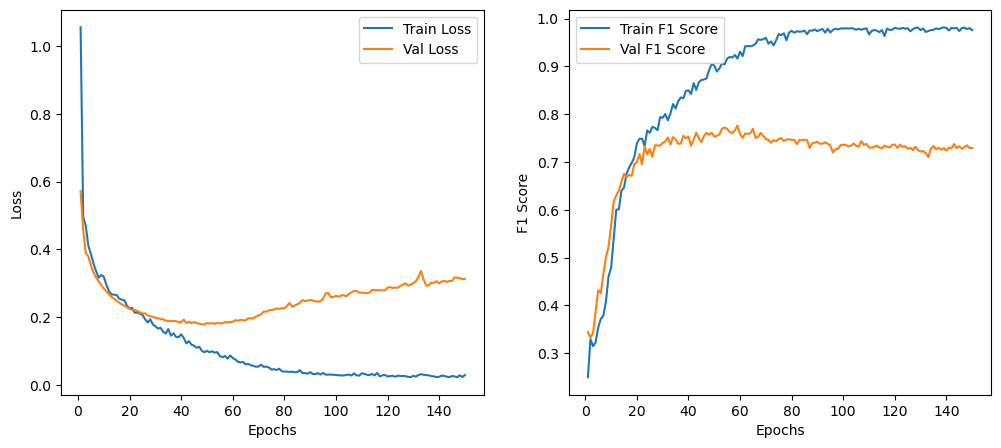

In [14]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()